# NAS-BNN Full Pipeline for CIFAR-10

This notebook orchestrates the entire NAS-BNN pipeline for the CIFAR-10 dataset.
It includes:

0.  Data Preparation (`prepare_cifar10.py`)
0.5. Supernet OPs Range Check (`check_ops.py`)
1.  Supernet Training (`train.py`)
2.  Evolutionary Architecture Search (`search.py`)
2.5. Inspection of Search Results (Manual Step Placeholder)
3.  Testing of Searched Architectures (`test.py`)
4.  Fine-tuning of Searched Architectures (`train_single.py`)

**Important Notes Before Running:**
*   Ensure your Python environment (e.g., `nasbnn`) is selected as the kernel for this notebook.
*   It's recommended to set the `CUDA_VISIBLE_DEVICES` environment variable in the terminal *before* launching Jupyter Lab/Notebook for consistent GPU selection by PyTorch, e.g., `set CUDA_VISIBLE_DEVICES=0` (cmd) or `$env:CUDA_VISIBLE_DEVICES="0"` (PowerShell). While we try to set it in the first code cell, its effect on `!` shell commands can sometimes be limited to that cell.
*   The script uses placeholder values for OPs ranges and keys to test/finetune. You will be prompted to review/update these after certain steps. For a fully automated run without intervention, you would need to pre-set these accurately.
*   Long-running cells (especially Supernet Training and Search) are generally more robustly run from standalone scripts in a terminal. This notebook is primarily for demonstration and step-by-step execution.

In [ ]:
# Cell 2: Code (Environment Setup, Configuration, CUDA Check, and Helper Functions)

import os
import subprocess
import torch 
import re # For the log parsing helper function
import pandas as pd # For the analysis part using DataFrames
from IPython.display import display # For displaying DataFrames nicely
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

print("--- Loading and Analyzing Search & Fine-tuning Results ---")

# --- Configuration from Main Notebook Setup (Cell 2 of run_all.ipynb) ---
# These should already be defined if you ran Cell 2 of the notebook:
# search_info_file, base_work_dir, search_output_dir
# ops_key_to_test1, ops_key_to_test2

# --- Helper function to parse log files (can also be in Cell 2) ---
def parse_accuracy_from_log(log_file_path):
    top1_accuracy = None
    if not os.path.exists(log_file_path):
        print(f"Warning: Log file not found at {log_file_path}")
        return None
    try:
        with open(log_file_path, 'r') as f: lines = f.readlines()
        for line in reversed(lines):
            match_test = re.search(r"INFO - top1: (\d+\.\d+)", line)
            if match_test: top1_accuracy = float(match_test.group(1)); break
            match_train_single = re.search(r"INFO -  \* Acc@1 (\d+\.\d+)", line)
            if match_train_single: top1_accuracy = float(match_train_single.group(1)); break
        if top1_accuracy is not None: print(f"Parsed accuracy {top1_accuracy:.2f}% from {os.path.basename(log_file_path)}")
        else: print(f"Warning: Could not parse Top-1 accuracy from {log_file_path}")
    except Exception as e: print(f"Error parsing log file {log_file_path}: {e}"); return None
    return top1_accuracy

# --- 1. Load Search Results (info.pth.tar) ---
print(f"\nLoading main search results from: {search_info_file}")
search_results = None
vis_dict = {}
final_pareto_global_dict = {}
final_pareto_global_tuples = set()
all_evaluated_candidates_data = [] # For scatter plot
df_all_plot = pd.DataFrame()
df_final_pareto_table = pd.DataFrame()

try:
    search_results = torch.load(search_info_file, map_location='cpu')
    vis_dict = search_results.get('vis_dict', {})
    final_pareto_global_dict = search_results.get('pareto_global', {})
    if final_pareto_global_dict:
        final_pareto_global_tuples = set(final_pareto_global_dict.values())
    print(f"Search results loaded: {len(vis_dict)} unique architectures in vis_dict, {len(final_pareto_global_dict)} on Pareto front.")

    # Prepare data for scatter plot
    for cand_tuple_key, data in vis_dict.items():
        current_cand_tuple_for_check = ast.literal_eval(cand_tuple_key) if isinstance(cand_tuple_key, str) else cand_tuple_key
        if 'acc' in data and 'ops' in data:
            all_evaluated_candidates_data.append({
                'ops': data['ops'], 'accuracy': data['acc'],
                'on_final_pareto': current_cand_tuple_for_check in final_pareto_global_tuples
            })
    if all_evaluated_candidates_data:
        df_all_plot = pd.DataFrame(all_evaluated_candidates_data)

    # Prepare data for Pareto table
    pareto_table_data = []
    if final_pareto_global_dict:
        for ops_key, cand_tuple_val in final_pareto_global_dict.items():
            cand_tuple_key_for_vis = ast.literal_eval(cand_tuple_val) if isinstance(cand_tuple_val, str) else cand_tuple_val
            if cand_tuple_key_for_vis in vis_dict:
                entry = vis_dict[cand_tuple_key_for_vis]
                pareto_table_data.append({
                    'OPs_Bucket_Key': ops_key, 'Accuracy (%)': entry['acc'],
                    'OPs (M)': entry['ops'], 'Architecture': str(cand_tuple_key_for_vis)
                })
        if pareto_table_data:
            df_final_pareto_table = pd.DataFrame(pareto_table_data).sort_values(by='OPs (M)').reset_index(drop=True)

except Exception as e:
    print(f"ERROR processing search results: {e}")

# --- 2. Collect Test and Fine-tuning Results by Parsing Logs ---
print("\n--- Collecting Test and Fine-tuning Accuracies from Logs ---")
test_log_path_key0 = os.path.join(search_output_dir, f"test_ops_key{ops_key_to_test1}", "test.log")
test_log_path_key1 = os.path.join(search_output_dir, f"test_ops_key{ops_key_to_test2}", "test.log")
finetune_log_path_key0 = os.path.join(base_work_dir, f"finetuned_ops_key{ops_key_to_test1}", "train.log")
finetune_log_path_key1 = os.path.join(base_work_dir, f"finetuned_ops_key{ops_key_to_test2}", "train.log")

ops_val_key0_str = vis_dict.get(final_pareto_global_dict.get(ops_key_to_test1), {}).get('ops', 'N/A')
ops_val_key1_str = vis_dict.get(final_pareto_global_dict.get(ops_key_to_test2), {}).get('ops', 'N/A')

test_acc_key0 = parse_accuracy_from_log(test_log_path_key0)
test_acc_key1 = parse_accuracy_from_log(test_log_path_key1)
finetune_acc_key0 = parse_accuracy_from_log(finetune_log_path_key0)
finetune_acc_key1 = parse_accuracy_from_log(finetune_log_path_key1)

comparison_data = []
if test_acc_key0 is not None:
    comparison_data.append({'Key': ops_key_to_test1, 'Stage': 'Searched (test.py)', 'OPs (M)': ops_val_key0_str, 'Top-1 Acc (%)': test_acc_key0})
if finetune_acc_key0 is not None:
    comparison_data.append({'Key': ops_key_to_test1, 'Stage': 'Fine-tuned', 'OPs (M)': ops_val_key0_str, 'Top-1 Acc (%)': finetune_acc_key0})
if test_acc_key1 is not None:
    comparison_data.append({'Key': ops_key_to_test2, 'Stage': 'Searched (test.py)', 'OPs (M)': ops_val_key1_str, 'Top-1 Acc (%)': test_acc_key1})
if finetune_acc_key1 is not None:
    comparison_data.append({'Key': ops_key_to_test2, 'Stage': 'Fine-tuned', 'OPs (M)': ops_val_key1_str, 'Top-1 Acc (%)': finetune_acc_key1})

df_comparison = pd.DataFrame() # Define df_comparison before the if block
if comparison_data:
    df_comparison = pd.DataFrame(comparison_data)
    print("\n--- Comparison of Pre-Finetuning and Post-Finetuning Accuracies ---")
    display(df_comparison)
else:
    print("\nCould not gather sufficient data for comparison table from logs.")


print("--- Initial Environment Setup and Configuration ---")

# --- Configuration Variables ---
dataset_name = "cifar10"
architecture_name = "superbnn_cifar10"
global_workers = 0 

data_path = "./data/CIFAR10" 
base_work_dir = "./work_dirs/cifar10_nasbnn_exp_notebook_run" # For this notebook run
supernet_checkpoint_path = f"{base_work_dir}/checkpoint.pth.tar"
search_output_dir = f"{base_work_dir}/search"
search_info_file = f"{search_output_dir}/info.pth.tar"

# Supernet Training Params
train_supernet_epochs = 50
train_supernet_batch_size = 2048
train_supernet_lr = "2.5e-3"
train_supernet_wd = "5e-6"

# Search Params
search_max_epochs = 10
search_population_num = 50
search_m_prob = 0.2
search_crossover_num = 10
search_mutation_num = 10
search_ops_min = 0.03   # Default, review after check_ops.py
search_ops_max = 1.1    # Default, review after check_ops.py
search_step = 0.05
search_max_train_iters = 10
search_train_batch_size = 128
search_test_batch_size = 128

# Test Params
test_max_train_iters = 10
test_train_batch_size = 128 
test_test_batch_size = 128
ops_key_to_test1 = 0    # Placeholder, update after search
ops_key_to_test2 = 1    # Placeholder, update after search

# Fine-tuning Params
finetune_batch_size = 64
finetune_lr = "1e-5"
finetune_wd = 0
finetune_epochs = 25

# --- Environment Variable Setup ---
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 
os.environ["PYTHONUNBUFFERED"] = "1"
print(f"INFO: Attempted to set CUDA_VISIBLE_DEVICES to: {os.environ.get('CUDA_VISIBLE_DEVICES')}")
print(f"INFO: Attempted to set PYTHONUNBUFFERED to: {os.environ.get('PYTHONUNBUFFERED')}")
print(f"INFO: Current working directory: {os.getcwd()}")
print(f"INFO: Output for this run will be in: {base_work_dir}")
print("---------------------------------")

# --- CUDA Installation and GPU Check ---
print("--- CUDA Installation and GPU Check ---")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA version reported by PyTorch (torch.version.cuda): {torch.version.cuda}")
    print(f"Number of GPUs available to PyTorch: {torch.cuda.device_count()}")
    
    try:
        cuda_device_idx = 0 
        torch.cuda.set_device(cuda_device_idx) 
        print(f"Current PyTorch CUDA device (after setting to {cuda_device_idx}): {torch.cuda.current_device()}")
        print(f"GPU name for PyTorch cuda:{cuda_device_idx}: {torch.cuda.get_device_name(torch.cuda.current_device())}")
        
        print("\nAttempting a small model and tensor operation on CUDA device...")
        model_test = torch.nn.Linear(10,1).to(torch.device(f"cuda:{cuda_device_idx}"))
        # print(f"Test model device: {next(model_test.parameters()).device}") # Removed due to potential "StopIteration" if model has no parameters
        
        a = torch.randn(5, 10).to(torch.device(f"cuda:{cuda_device_idx}"))
        # print(f"Test tensor 'a' device: {a.device}")
        
        b = model_test(a)
        # print(f"Test output 'b' device: {b.device}")
        print(f"Small CUDA op successful. Output sum: {b.sum().item()}")
        
    except Exception as e:
        print(f"Error during CUDA operations: {e}")
else:
    print("CUDA not available, cannot perform GPU tests with PyTorch CUDA backend.")

cuda_visible_devices_env = os.environ.get('CUDA_VISIBLE_DEVICES')
print(f"\nChecking environment variable CUDA_VISIBLE_DEVICES (as seen by Python os.environ):")
if cuda_visible_devices_env:
    print(f"CUDA_VISIBLE_DEVICES is set to: {cuda_visible_devices_env}")
else:
    print("CUDA_VISIBLE_DEVICES is NOT set or is empty in os.environ.")
print("---------------------------------")

# --- Helper Function for Log Parsing (used by Analysis Cells later) ---
def parse_accuracy_from_log(log_file_path):
    """
    Parses the last Top-1 accuracy from a test.log or train_single.py's train.log.
    For test.log, expects lines like: 'INFO - top1: 51.12 top5: 93.60'
    For train_single.py's train.log, expects lines like: 'INFO -  * Acc@1 56.820 Acc@5 95.040'
    """
    top1_accuracy = None
    if not os.path.exists(log_file_path):
        print(f"Warning: Log file not found at {log_file_path}")
        return None
    try:
        with open(log_file_path, 'r') as f: lines = f.readlines()
        for line in reversed(lines):
            # Pattern for test.py log: "INFO - top1: 51.12"
            match_test = re.search(r"INFO - top1: (\d+\.\d+)", line)
            if match_test:
                top1_accuracy = float(match_test.group(1))
                # print(f"Parsed test.py accuracy {top1_accuracy:.2f}% from {os.path.basename(log_file_path)}") # Optional: for more verbose parsing
                break
            
            # Pattern for train_single.py log: "INFO -  * Acc@1 56.820"
            match_train_single = re.search(r"INFO -  \* Acc@1 (\d+\.\d+)", line)
            if match_train_single:
                top1_accuracy = float(match_train_single.group(1))
                # print(f"Parsed train_single.py accuracy {top1_accuracy:.2f}% from {os.path.basename(log_file_path)}") # Optional
                break
        
        if top1_accuracy is None:
            print(f"Warning: Could not parse Top-1 accuracy from {log_file_path}")
    except Exception as e:
        print(f"Error parsing log file {log_file_path}: {e}")
        return None
    return top1_accuracy
# --- End Helper Function ---

# Create base work directory if it doesn't exist
os.makedirs(base_work_dir, exist_ok=True)
print(f"INFO: Ensured base work directory exists: {base_work_dir}")
print("--- Configuration and Setup Cell Complete ---")

--- Initial Environment Setup and Configuration ---
INFO: Attempted to set CUDA_VISIBLE_DEVICES to: 0
INFO: Attempted to set PYTHONUNBUFFERED to: 1
INFO: Current working directory: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test 06
INFO: Output for this run will be in: ./work_dirs/cifar10_nasbnn_exp_notebook_run
---------------------------------
--- CUDA Installation and GPU Check ---
PyTorch version: 2.7.0+cu128
CUDA available: True
CUDA version reported by PyTorch (torch.version.cuda): 12.8
Number of GPUs available to PyTorch: 1
Current PyTorch CUDA device (after setting to 0): 0
GPU name for PyTorch cuda:0: NVIDIA GeForce RTX 4050 Laptop GPU

Attempting a small model and tensor operation on CUDA device...
Small CUDA op successful. Output sum: 1.4701865911483765

Checking environment variable CUDA_VISIBLE_DEVICES (as seen by Python os.environ):
CUDA_VISIBLE_DEVICES is set to: 0
---------------------------------
INFO: Ensured base work directory exists: ./work_dirs/cifa

## Step 0: Prepare CIFAR-10 Data
This step runs `prepare_cifar10.py` to download (if necessary) and structure the CIFAR-10 dataset into the `ImageFolder` format expected by the subsequent scripts.

In [2]:
print("Step 0: Preparing CIFAR-10 Data...")
# Using ! for direct shell execution. Adjust if your Jupyter kernel uses a different shell.
# For Windows/cmd, caret ^ might work for line continuation IF the kernel supports it.
# Single line is safest for `!` commands.
!python prepare_cifar10.py
print("INFO: CIFAR-10 Data Preparation assumed complete.")

Step 0: Preparing CIFAR-10 Data...
Preparing ImageFolder structure for CIFAR-10...
Processing new training set...
Processing new validation set...
Processing original test set (for final evaluation)...
CIFAR-10 data preparation complete.
Train data: ./data/CIFAR10\train
Validation data (for NAS): ./data/CIFAR10\val
Test data (original test): ./data/CIFAR10\test
INFO: CIFAR-10 Data Preparation assumed complete.



  0%|          | 0.00/170M [00:00<?, ?B/s]
  0%|          | 32.8k/170M [00:00<09:45, 291kB/s]
  0%|          | 65.5k/170M [00:00<09:56, 286kB/s]
  0%|          | 98.3k/170M [00:00<10:03, 282kB/s]
  0%|          | 229k/170M [00:00<04:36, 615kB/s] 
  0%|          | 459k/170M [00:00<02:34, 1.10MB/s]
  1%|          | 918k/170M [00:00<01:22, 2.06MB/s]
  1%|          | 1.87M/170M [00:00<00:41, 4.06MB/s]
  2%|▏         | 3.31M/170M [00:00<00:23, 7.01MB/s]
  3%|▎         | 5.08M/170M [00:01<00:17, 9.69MB/s]
  4%|▍         | 6.52M/170M [00:01<00:14, 11.0MB/s]
  5%|▍         | 8.16M/170M [00:01<00:12, 12.6MB/s]
  6%|▌         | 9.47M/170M [00:01<00:13, 12.0MB/s]
  6%|▋         | 10.8M/170M [00:01<00:13, 12.2MB/s]
  7%|▋         | 12.4M/170M [00:01<00:12, 13.1MB/s]
  8%|▊         | 14.1M/170M [00:01<00:11, 14.1MB/s]
  9%|▉         | 15.7M/170M [00:01<00:10, 14.5MB/s]
 10%|█         | 17.2M/170M [00:01<00:10, 14.7MB/s]
 11%|█         | 18.8M/170M [00:01<00:10, 15.0MB/s]
 12%|█▏        | 20.6M/170

## Step 0.5: Check Supernet OPs Range
This step runs `check_ops.py` to determine the theoretical minimum and maximum OPs (Mega Operations) for the `superbnn_cifar10` architecture. 
**ACTION:** Review its output. If the `$SearchOpsMin` and `$SearchOpsMax` variables defined in Cell 2 (Configuration) are not appropriate based on this output, **manually edit them in Cell 2 and re-run Cell 2** before proceeding.

In [9]:
import subprocess
import sys

print("Step 0.5: Check Supernet OPs Range...")

# Command to run check_ops.py
# We use sys.executable to ensure we're using the Python from the current Jupyter kernel
command_to_run = [sys.executable, "check_ops.py"]
print(f"Running: {' '.join(command_to_run)}")

try:
    # Run the command and capture its output
    result = subprocess.run(command_to_run, capture_output=True, text=True, check=False) # check=False to see output even on error
    
    print("\n--- Output from check_ops.py ---")
    if result.stdout:
        print("STDOUT:")
        print(result.stdout)
    if result.stderr:
        print("STDERR:")
        print(result.stderr)
    print("--- End of check_ops.py Output ---\n")

    if result.returncode != 0:
        print(f"WARNING: check_ops.py ran with errors (return code: {result.returncode}). Please check output above.")

except FileNotFoundError:
    print(f"ERROR: Could not find script 'check_ops.py' or Python interpreter '{sys.executable}'. Make sure they are in the correct path.")
except Exception as e:
    print(f"An unexpected error occurred while running check_ops.py: {e}")

print(f"ACTION: Review the OPs range from the output above. Current SearchOpsMin = {search_ops_min}, SearchOpsMax = {search_ops_max} in config (Cell 2).")
input("Press Enter in the input box below to continue once you've reviewed/updated OPs parameters in Cell 2 (if needed), or stop kernel to edit.")

Step 0.5: Check Supernet OPs Range...
Running: c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test 06\nasbnn\Scripts\python.exe check_ops.py

--- Output from check_ops.py ---
STDOUT:
Smallest candidate OPs: 0.04 M
Biggest candidate OPs: 1.06 M

--- End of check_ops.py Output ---

ACTION: Review the OPs range from the output above. Current SearchOpsMin = 0.03, SearchOpsMax = 1.1 in config (Cell 2).


''

## Step 1: Train Supernet
This step trains the `superbnn_cifar10` supernet. This can be time-consuming.
Output will be in the `$BaseWorkDir` defined in Cell 2.

In [5]:
print(f"Step 1: Training Supernet (Output: {base_work_dir})...")
# Using f-strings to build the command
# For multi-line `!` commands, ensure your Jupyter kernel's shell supports the line continuation used (e.g., `\` for bash)
# Or write it as one long line.

train_command = f"""
python train.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    -b {train_supernet_batch_size} \
    --lr {train_supernet_lr} \
    --wd {train_supernet_wd} \
    --epochs {train_supernet_epochs} \
    {data_path} \
    {base_work_dir} \
    --gpu 0 \
    --workers {global_workers} \
    --print-freq 50 \
    --save-freq 5
"""
# Remove newlines for single-line execution with !
train_command_single_line = " ".join(train_command.split())
!{train_command_single_line}
print(f"INFO: Supernet Training assumed complete. Checkpoint: {supernet_checkpoint_path}")

Step 1: Training Supernet (Output: ./work_dirs/cifar10_nasbnn_exp_notebook_run)...
Use GPU: 0 for training
Use cosine scheduler
INFO: Supernet Training assumed complete. Checkpoint: ./work_dirs/cifar10_nasbnn_exp_notebook_run/checkpoint.pth.tar


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test 02\train.py:202: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-05-19 15:03:04,673 - Train - INFO - Namespace(data='./data/CIFAR10', logdir='./work_dirs/cifar10_nasbnn_exp_notebook_run', arch='superbnn_cifar10', dataset='cifar10', workers=0, epochs=50, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, label_smooth=0.1, batch_size=2048, lr=0.0025, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=5e-06, distill=False, print_freq=50, save_freq=5, resume='', evaluate=False, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, gpu=0, multiprocessing_distributed=False, distributed=False)
2025-05-19 15:03:04,676 - Train - INFO - => creating model 'superbnn_cifar10'


## Step 2: Search Architectures
This step performs the evolutionary search using the trained supernet. This can also be time-consuming.
Output will be in `$SearchOutputDir`.

In [7]:
print(f"Step 2: Searching Architectures (Output: {search_output_dir})...")
print(f"INFO: Using SearchOpsMin: {search_ops_min}, SearchOpsMax: {search_ops_max}")
os.makedirs(search_output_dir, exist_ok=True)

search_command = f"""
python search.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --max-epochs {search_max_epochs} \
    --population-num {search_population_num} \
    --m-prob {search_m_prob} \
    --crossover-num {search_crossover_num} \
    --mutation-num {search_mutation_num} \
    --ops-min {search_ops_min} \
    --ops-max {search_ops_max} \
    --step {search_step} \
    --max-train-iters {search_max_train_iters} \
    --train-batch-size {search_train_batch_size} \
    --test-batch-size {search_test_batch_size} \
    --workers {global_workers} \
    {supernet_checkpoint_path} \
    {data_path} \
    {search_output_dir} \
    --gpu 0
"""
search_command_single_line = " ".join(search_command.split())
!{search_command_single_line}
print(f"INFO: Search assumed complete. Results: {search_info_file}")

Step 2: Searching Architectures (Output: ./work_dirs/cifar10_nasbnn_exp_notebook_run/search)...
INFO: Using SearchOpsMin: 0.03, SearchOpsMax: 1.1
Use GPU: 0 for training
INFO: Search assumed complete. Results: ./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test 06\search.py:688: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-05-21 15:40:05,475 - Search - INFO - Namespace(supernet='./work_dirs/cifar10_nasbnn_exp_notebook_run/checkpoint.pth.tar', data='./data/CIFAR10', logdir='./work_dirs/cifar10_nasbnn_exp_notebook_run/search', arch='superbnn_cifar10', dataset='cifar10', workers=0, max_epochs=10, population_num=50, m_prob=0.2, crossover_num=10, mutation_num=10, ops_min=0.03, ops_max=1.1, step=0.05, max_train_iters=10, train_batch_size=128, test_batch_size=128, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-05-21 15:40:05,475 - Search - INFO - => creating model 'superbnn_cifar10'
2025-05-21 15:40:05,558 - Search - INFO - => loading checkpoint './work_dirs/

## Step 2.5: Inspect Search Results
The search has produced `$SearchInfoFile`.
**ACTION:** Inspect this file to identify the keys for promising architectures. You can use your `info.pth.tar.py` script or the Python one-liner provided in the PowerShell script.
The notebook will pause here. **Manually update the `ops_key_to_test1` and `ops_key_to_test2` variables in Cell 2 (Configuration) with the keys you want to test/fine-tune, then re-run Cell 2** before proceeding to the next steps.

In [11]:
print(f"Step 2.5: Inspect Search Results from: {search_info_file}")
print(f"ACTION: Manually update ops_key_to_test1/ops_key_to_test2 in Cell 2 if the defaults ({ops_key_to_test1}, {ops_key_to_test2}) are not desired.")
# Example one-liner to print keys (run this in a new cell if you want to see output before continuing)
# !python -c "import torch; r = torch.load('{search_info_file}', map_location='cpu'); print('Pareto Keys:', r.get('pareto_global', {{}}).keys())"
input("Press Enter in the input box below once you have reviewed search results and updated keys in Cell 2 (if needed). Then RE-RUN CELL 2 before running next cells.")

Step 2.5: Inspect Search Results from: ./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar
ACTION: Manually update ops_key_to_test1/ops_key_to_test2 in Cell 2 if the defaults (0, 1) are not desired.


''

## Step 3a: Test Architecture for OPs Key 1
Testing the architecture corresponding to the first chosen OPs key.

In [12]:
test_output_dir1 = f"{search_output_dir}/test_ops_key{ops_key_to_test1}"
print(f"Step 3a: Testing Architecture for OPs Key {ops_key_to_test1} (Output: {test_output_dir1})...")
os.makedirs(test_output_dir1, exist_ok=True)

test_command1 = f"""
python test.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --ops {ops_key_to_test1} \
    --max-train-iters {test_max_train_iters} \
    --train-batch-size {test_train_batch_size} \
    --test-batch-size {test_test_batch_size} \
    --workers {global_workers} \
    {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {test_output_dir1} \
    --gpu 0
"""
test_command1_single_line = " ".join(test_command1.split())
!{test_command1_single_line}
print(f"INFO: Test for OPs Key {ops_key_to_test1} assumed complete.")

Step 3a: Testing Architecture for OPs Key 0 (Output: ./work_dirs/cifar10_nasbnn_exp_notebook_run/search/test_ops_key0)...
Use GPU: 0 for training
calibrate running stats for BN....
starting test....
INFO: Test for OPs Key 0 assumed complete.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test 06\test.py:122: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-05-21 16:29:30,219 - Test - INFO - Namespace(supernet='./work_dirs/cifar10_nasbnn_exp_notebook_run/checkpoint.pth.tar', data='./data/CIFAR10', checkpoint='./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar', logdir='./work_dirs/cifar10_nasbnn_exp_notebook_run/search/test_ops_key0', arch='superbnn_cifar10', dataset='cifar10', workers=0, ops=0, max_train_iters=10, train_batch_size=128, test_batch_size=128, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-05-21 16:29:30,219 - Test - INFO - => creating model 'superbnn_cifar10'
2025-05-21 16:29:30,326 - Test - INFO - => creating model 'superbnn_cifar10'
2025-05-21 16:29:30,327 - 

## Step 3b: Test Architecture for OPs Key 2
Testing the architecture corresponding to the second chosen OPs key.

In [13]:
test_output_dir2 = f"{search_output_dir}/test_ops_key{ops_key_to_test2}"
print(f"Step 3b: Testing Architecture for OPs Key {ops_key_to_test2} (Output: {test_output_dir2})...")
os.makedirs(test_output_dir2, exist_ok=True)

test_command2 = f"""
python test.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    --ops {ops_key_to_test2} \
    --max-train-iters {test_max_train_iters} \
    --train-batch-size {test_train_batch_size} \
    --test-batch-size {test_test_batch_size} \
    --workers {global_workers} \
    {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {test_output_dir2} \
    --gpu 0
"""
test_command2_single_line = " ".join(test_command2.split())
!{test_command2_single_line}
print(f"INFO: Test for OPs Key {ops_key_to_test2} assumed complete.")

Step 3b: Testing Architecture for OPs Key 1 (Output: ./work_dirs/cifar10_nasbnn_exp_notebook_run/search/test_ops_key1)...
Use GPU: 0 for training
calibrate running stats for BN....
starting test....
INFO: Test for OPs Key 1 assumed complete.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test 06\test.py:122: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-05-21 16:30:01,699 - Test - INFO - Namespace(supernet='./work_dirs/cifar10_nasbnn_exp_notebook_run/checkpoint.pth.tar', data='./data/CIFAR10', checkpoint='./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar', logdir='./work_dirs/cifar10_nasbnn_exp_notebook_run/search/test_ops_key1', arch='superbnn_cifar10', dataset='cifar10', workers=0, ops=1, max_train_iters=10, train_batch_size=128, test_batch_size=128, gpu=0, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='nccl', seed=0, multiprocessing_distributed=False, distributed=False)
2025-05-21 16:30:01,699 - Test - INFO - => creating model 'superbnn_cifar10'
2025-05-21 16:30:01,814 - Test - INFO - => creating model 'superbnn_cifar10'
2025-05-21 16:30:01,815 - 

## Step 4a: Fine-tune Architecture for OPs Key 1
Fine-tuning the architecture corresponding to the first chosen OPs key.

In [14]:
finetune_output_dir1 = f"{base_work_dir}/finetuned_ops_key{ops_key_to_test1}"
print(f"Step 4a: Fine-tuning for OPs Key {ops_key_to_test1} (Output: {finetune_output_dir1})...")
os.makedirs(finetune_output_dir1, exist_ok=True)

finetune_command1 = f"""
python train_single.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    -b {finetune_batch_size} \
    --lr {finetune_lr} \
    --wd {finetune_wd} \
    --epochs {finetune_epochs} \
    --ops {ops_key_to_test1} \
    --workers {global_workers} \
    --pretrained {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {finetune_output_dir1} \
    --gpu 0
"""
finetune_command1_single_line = " ".join(finetune_command1.split())
!{finetune_command1_single_line}
print(f"INFO: Fine-tuning for OPs Key {ops_key_to_test1} assumed complete.")

Step 4a: Fine-tuning for OPs Key 0 (Output: ./work_dirs/cifar10_nasbnn_exp_notebook_run/finetuned_ops_key0)...
Use GPU: 0 for training
Use cosine scheduler
INFO: Fine-tuning for OPs Key 0 assumed complete.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test 06\train_single.py:203: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-05-21 16:30:26,564 - Train - INFO - Namespace(data='./data/CIFAR10', checkpoint='./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar', logdir='./work_dirs/cifar10_nasbnn_exp_notebook_run/finetuned_ops_key0', arch='superbnn_cifar10', dataset='cifar10', workers=0, ops=0, epochs=25, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, batch_size=64, lr=1e-05, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=0.0, print_freq=100, save_freq=1, resume='', pretrained='./work_dirs/cifar10_nasbnn_exp_notebook_run/checkpoint.pth.tar', evaluate=False, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='ncc

## Step 4b: Fine-tune Architecture for OPs Key 2
Fine-tuning the architecture corresponding to the second chosen OPs key.

In [15]:
finetune_output_dir2 = f"{base_work_dir}/finetuned_ops_key{ops_key_to_test2}"
print(f"Step 4b: Fine-tuning for OPs Key {ops_key_to_test2} (Output: {finetune_output_dir2})...")
os.makedirs(finetune_output_dir2, exist_ok=True)

finetune_command2 = f"""
python train_single.py \
    --dataset {dataset_name} \
    -a {architecture_name} \
    -b {finetune_batch_size} \
    --lr {finetune_lr} \
    --wd {finetune_wd} \
    --epochs {finetune_epochs} \
    --ops {ops_key_to_test2} \
    --workers {global_workers} \
    --pretrained {supernet_checkpoint_path} \
    {data_path} \
    {search_info_file} \
    {finetune_output_dir2} \
    --gpu 0
"""
finetune_command2_single_line = " ".join(finetune_command2.split())
!{finetune_command2_single_line}
print(f"INFO: Fine-tuning for OPs Key {ops_key_to_test2} assumed complete.")

Step 4b: Fine-tuning for OPs Key 1 (Output: ./work_dirs/cifar10_nasbnn_exp_notebook_run/finetuned_ops_key1)...
Use GPU: 0 for training
Use cosine scheduler
INFO: Fine-tuning for OPs Key 1 assumed complete.


c:\Users\SMoha\Desktop\Temporary\UniGe\Internship\NAS-BNN\Test 06\train_single.py:203: UserWarning: You have chosen a specific GPU. This will completely disable data parallelism.
  warnings.warn('You have chosen a specific GPU. This will completely '
2025-05-21 16:48:47,499 - Train - INFO - Namespace(data='./data/CIFAR10', checkpoint='./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar', logdir='./work_dirs/cifar10_nasbnn_exp_notebook_run/finetuned_ops_key1', arch='superbnn_cifar10', dataset='cifar10', workers=0, ops=1, epochs=25, start_epoch=0, warm_up=False, warm_up_multiplier=1, warm_up_epochs=5, cutout=False, cutout_length=16, batch_size=64, lr=1e-05, lr_scheduler='CosineAnnealingLR', step_size=30, gamma=0.1, milestones=[80, 120], momentum=0.9, weight_decay=0.0, print_freq=100, save_freq=1, resume='', pretrained='./work_dirs/cifar10_nasbnn_exp_notebook_run/checkpoint.pth.tar', evaluate=False, world_size=-1, rank=-1, dist_url='tcp://224.66.41.62:23456', dist_backend='ncc

## Step 5: Analysis and Visualization of Pipeline Results

This section loads the primary result of the architecture search (`info.pth.tar`) and the logs from testing and fine-tuning to provide an overview of the discovered architectures and their performance.

In [ ]:
print("--- Loading and Analyzing Search & Fine-tuning Results ---")

# --- Configuration from Main Notebook Setup (Cell 2 of run_all.ipynb) ---
# These should already be defined if you ran Cell 2 of the notebook:
# search_info_file, base_work_dir, search_output_dir
# ops_key_to_test1, ops_key_to_test2

# --- Helper function to parse log files (can also be in Cell 2) ---
def parse_accuracy_from_log(log_file_path):
    top1_accuracy = None
    if not os.path.exists(log_file_path):
        print(f"Warning: Log file not found at {log_file_path}")
        return None
    try:
        with open(log_file_path, 'r') as f: lines = f.readlines()
        for line in reversed(lines):
            match_test = re.search(r"INFO - top1: (\d+\.\d+)", line)
            if match_test: top1_accuracy = float(match_test.group(1)); break
            match_train_single = re.search(r"INFO -  \* Acc@1 (\d+\.\d+)", line)
            if match_train_single: top1_accuracy = float(match_train_single.group(1)); break
        if top1_accuracy is not None: print(f"Parsed accuracy {top1_accuracy:.2f}% from {os.path.basename(log_file_path)}")
        else: print(f"Warning: Could not parse Top-1 accuracy from {log_file_path}")
    except Exception as e: print(f"Error parsing log file {log_file_path}: {e}"); return None
    return top1_accuracy

# --- 1. Load Search Results (info.pth.tar) ---
print(f"\nLoading main search results from: {search_info_file}")
search_results = None
vis_dict = {}
final_pareto_global_dict = {}
final_pareto_global_tuples = set()
all_evaluated_candidates_data = [] # For scatter plot
df_all_plot = pd.DataFrame()
df_final_pareto_table = pd.DataFrame()

try:
    search_results = torch.load(search_info_file, map_location='cpu')
    vis_dict = search_results.get('vis_dict', {})
    final_pareto_global_dict = search_results.get('pareto_global', {})
    if final_pareto_global_dict:
        final_pareto_global_tuples = set(final_pareto_global_dict.values())
    print(f"Search results loaded: {len(vis_dict)} unique architectures in vis_dict, {len(final_pareto_global_dict)} on Pareto front.")

    # Prepare data for scatter plot
    for cand_tuple_key, data in vis_dict.items():
        current_cand_tuple_for_check = ast.literal_eval(cand_tuple_key) if isinstance(cand_tuple_key, str) else cand_tuple_key
        if 'acc' in data and 'ops' in data:
            all_evaluated_candidates_data.append({
                'ops': data['ops'], 'accuracy': data['acc'],
                'on_final_pareto': current_cand_tuple_for_check in final_pareto_global_tuples
            })
    if all_evaluated_candidates_data:
        df_all_plot = pd.DataFrame(all_evaluated_candidates_data)

    # Prepare data for Pareto table
    pareto_table_data = []
    if final_pareto_global_dict:
        for ops_key, cand_tuple_val in final_pareto_global_dict.items():
            cand_tuple_key_for_vis = ast.literal_eval(cand_tuple_val) if isinstance(cand_tuple_val, str) else cand_tuple_val
            if cand_tuple_key_for_vis in vis_dict:
                entry = vis_dict[cand_tuple_key_for_vis]
                pareto_table_data.append({
                    'OPs_Bucket_Key': ops_key, 'Accuracy (%)': entry['acc'],
                    'OPs (M)': entry['ops'], 'Architecture': str(cand_tuple_key_for_vis)
                })
        if pareto_table_data:
            df_final_pareto_table = pd.DataFrame(pareto_table_data).sort_values(by='OPs (M)').reset_index(drop=True)

except Exception as e:
    print(f"ERROR processing search results: {e}")

# --- 2. Collect Test and Fine-tuning Results by Parsing Logs ---
print("\n--- Collecting Test and Fine-tuning Accuracies from Logs ---")
test_log_path_key0 = os.path.join(search_output_dir, f"test_ops_key{ops_key_to_test1}", "test.log")
test_log_path_key1 = os.path.join(search_output_dir, f"test_ops_key{ops_key_to_test2}", "test.log")
finetune_log_path_key0 = os.path.join(base_work_dir, f"finetuned_ops_key{ops_key_to_test1}", "train.log")
finetune_log_path_key1 = os.path.join(base_work_dir, f"finetuned_ops_key{ops_key_to_test2}", "train.log")

ops_val_key0_str = vis_dict.get(final_pareto_global_dict.get(ops_key_to_test1), {}).get('ops', 'N/A')
ops_val_key1_str = vis_dict.get(final_pareto_global_dict.get(ops_key_to_test2), {}).get('ops', 'N/A')

test_acc_key0 = parse_accuracy_from_log(test_log_path_key0)
test_acc_key1 = parse_accuracy_from_log(test_log_path_key1)
finetune_acc_key0 = parse_accuracy_from_log(finetune_log_path_key0)
finetune_acc_key1 = parse_accuracy_from_log(finetune_log_path_key1)

comparison_data = []
if test_acc_key0 is not None:
    comparison_data.append({'Key': ops_key_to_test1, 'Stage': 'Searched (test.py)', 'OPs (M)': ops_val_key0_str, 'Top-1 Acc (%)': test_acc_key0})
if finetune_acc_key0 is not None:
    comparison_data.append({'Key': ops_key_to_test1, 'Stage': 'Fine-tuned', 'OPs (M)': ops_val_key0_str, 'Top-1 Acc (%)': finetune_acc_key0})
if test_acc_key1 is not None:
    comparison_data.append({'Key': ops_key_to_test2, 'Stage': 'Searched (test.py)', 'OPs (M)': ops_val_key1_str, 'Top-1 Acc (%)': test_acc_key1})
if finetune_acc_key1 is not None:
    comparison_data.append({'Key': ops_key_to_test2, 'Stage': 'Fine-tuned', 'OPs (M)': ops_val_key1_str, 'Top-1 Acc (%)': finetune_acc_key1})

df_comparison = pd.DataFrame() # Define df_comparison before the if block
if comparison_data:
    df_comparison = pd.DataFrame(comparison_data)
    print("\n--- Comparison of Pre-Finetuning and Post-Finetuning Accuracies ---")
    display(df_comparison)
else:
    print("\nCould not gather sufficient data for comparison table from logs.")

--- Loading and Analyzing Search & Fine-tuning Results ---

Loading main search results from: ./work_dirs/cifar10_nasbnn_exp_notebook_run/search/info.pth.tar
Search results loaded: 250 unique architectures in vis_dict, 2 on Pareto front.

--- Collecting Test and Fine-tuning Accuracies from Logs ---
Parsed accuracy 51.12% from test.log
Parsed accuracy 51.64% from test.log
Parsed accuracy 57.44% from train.log
Parsed accuracy 56.82% from train.log

--- Comparison of Pre-Finetuning and Post-Finetuning Accuracies ---


,Key,Stage,OPs (M),Top-1 Acc (%)
0,0,Searched (test.py),0.851466,51.12
1,0,Fine-tuned,0.851466,57.44
2,1,Searched (test.py),1.023498,51.64
3,1,Fine-tuned,1.023498,56.82


### Pareto Front Visualization

Scatter plot showing all evaluated architectures from the search. Points on the final Pareto front are highlighted.

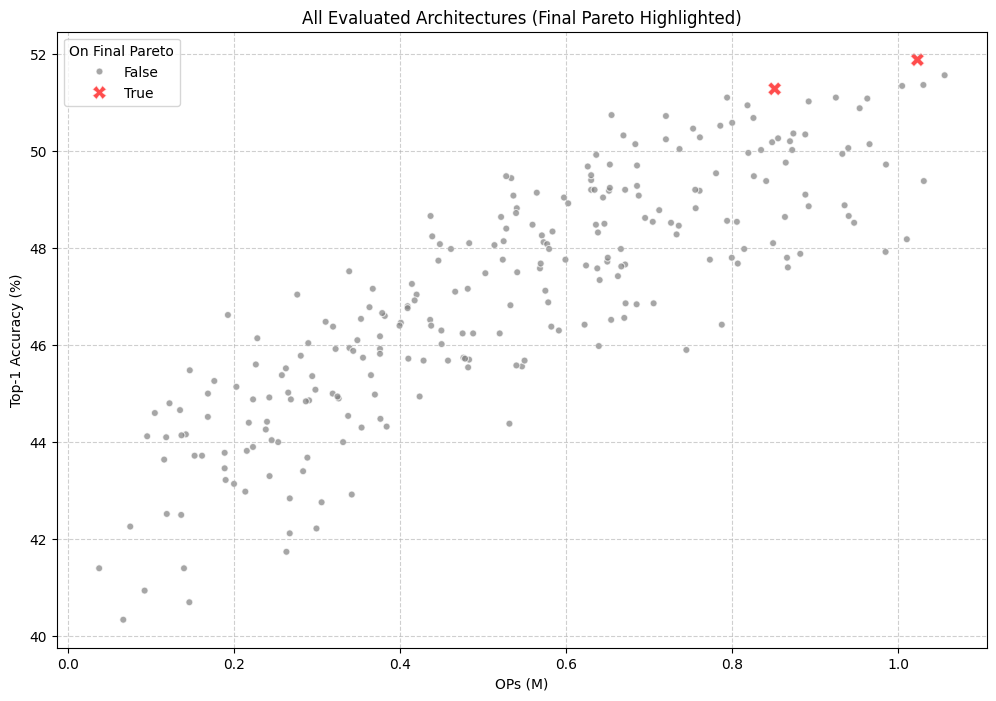

In [23]:
if not df_all_plot.empty:
    plt.figure(figsize=(12, 8))
    if 'on_final_pareto' in df_all_plot.columns and df_all_plot['on_final_pareto'].isin([True, False]).all():
        sns.scatterplot(data=df_all_plot, x='ops', y='accuracy', hue='on_final_pareto',
                        palette={True: 'red', False: 'grey'}, style='on_final_pareto', 
                        markers={True: 'X', False: '.'}, s=100 if any(df_all_plot['on_final_pareto']) else 70, # Make Pareto points bigger
                        alpha=0.7)
        plt.legend(title='On Final Pareto')
    else:
        print("Warning: 'on_final_pareto' column issue. Plotting all points uniformly.")
        sns.scatterplot(data=df_all_plot, x='ops', y='accuracy', color='grey', s=50, alpha=0.7)
    
    plt.title('All Evaluated Architectures (Final Pareto Highlighted)')
    plt.xlabel('OPs (M)')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
else:
    print("No data from vis_dict to plot the scatter of all evaluated architectures.")

### Table of Pareto Optimal Architectures

Details of the architectures found on the Pareto front.

In [24]:
if not df_final_pareto_table.empty:
    print("\n--- Final Architectures on the Pareto Front ---")
    with pd.option_context('display.max_colwidth', None, 'display.width', 1000):
        display(df_final_pareto_table[['OPs_Bucket_Key', 'OPs (M)', 'Accuracy (%)', 'Architecture']])
else:
    print("Final Pareto front table is empty or could not be generated.")


--- Final Architectures on the Pareto Front ---


,OPs_Bucket_Key,OPs (M),Accuracy (%),Architecture
0,0,0.851466,51.28,"(0, 0, 32, 3, 1, 1, 1, 0, 64, 3, 1, 1, 1, 1, 64, 3, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 128, 5, 2, 1, 3, 0, 256, 5, 2, 1, 3, 1, 256, 5, 2, 1)"
1,1,1.023498,51.88,"(0, 0, 32, 3, 1, 1, 1, 0, 64, 3, 1, 1, 1, 1, 64, 3, 1, 1, 2, 0, 128, 5, 1, 1, 2, 1, 128, 5, 1, 1, 3, 0, 256, 3, 2, 1, 3, 1, 256, 5, 2, 1)"


## Step 6: Analysis of Fine-Tuning Results

Compare pre-fine-tuning (from `test.py`) and post-fine-tuning (from `train_single.py`) accuracies.

### Fine-tuning Improvement Visualization
Bar chart showing the accuracy improvement due to fine-tuning.

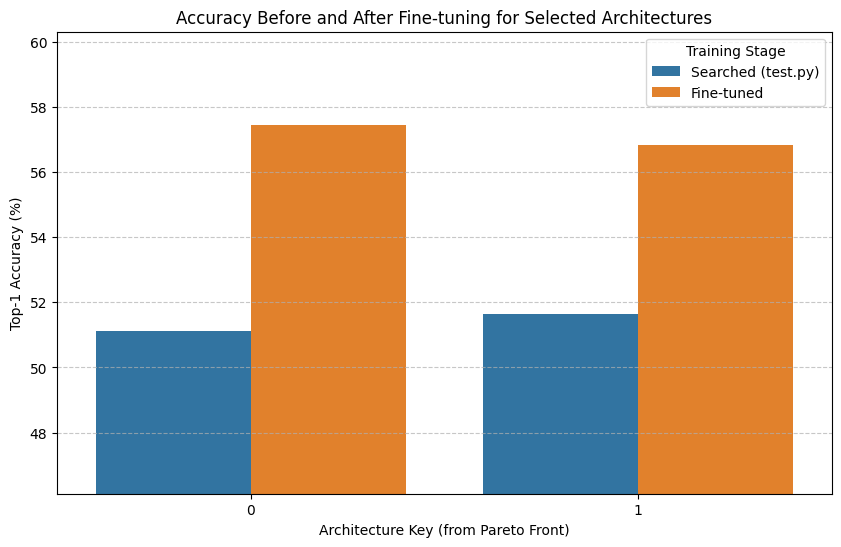

In [28]:
if not df_comparison.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_comparison, x='Key', y='Top-1 Acc (%)', hue='Stage')
    plt.title('Accuracy Before and After Fine-tuning for Selected Architectures')
    plt.xlabel('Architecture Key (from Pareto Front)')
    plt.ylabel('Top-1 Accuracy (%)')
    # Ensure y_min is not greater than y_max if all accuracies are 0 or None
    y_min_plot = 0
    if not df_comparison['Top-1 Acc (%)'].dropna().empty:
        y_min_plot = max(0, df_comparison['Top-1 Acc (%)'].dropna().min() - 5)
    plt.ylim(bottom=y_min_plot) 
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    plt.legend(title='Training Stage')
    plt.show()
else:
    print("No comparison data to plot for fine-tuning improvement.")

## Pipeline Complete
All steps of the NAS-BNN pipeline for CIFAR-10 have been executed. Check the respective output directories and logs for results.